In [1]:
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from mlresearch.utils import set_matplotlib_style
from recgame.environments import BaseEnvironment
from recgame.recourse import NFeatureRecourse
import seaborn as sns
import matplotlib.pyplot as plt

set_matplotlib_style(16)

# Some variables to define the problem
BIAS_FACTOR = 3
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)
N_CONTINUOUS = 2
N_AGENTS = 400

# NOTE: Categorical feature will be the "groups" variable; immutable + categorical

# Environment variables
N_LOANS = 20
ADAPTATION = .7
NEW_AGENTS = 20

# NFeatureRecourse for ranking

In [2]:
# from copy import deepcopy
# 
# class NFeatureRecourseRanking(NFeatureRecourse):
#     """
#     TODO: Add documentation.
#     
#     NOTE: This recourse method is designed for ranking models (i.e., linear regressions).
#     """
#     
#     def _get_coefficients(self):
#         """Utility function to retrieve model parameters."""
# 
#         model = deepcopy(self.model)
#         intercept = self.model.intercept_
#         coefficients = self.model.coef_
# 
#         # Adjusting the intercept to match the desired threshold.
#         intercept = 0.5 + intercept - self.threshold
#         model.intercept_ = intercept
# 
#         return intercept, coefficients, model

# NFeatureRecourse for ranking ignoring categorical feature

In [3]:
import warnings
from typing import Union
import numpy as np
from recgame.recourse.base import BaseRecourse
from copy import deepcopy

class NFeatureRecourseRanking(BaseRecourse):
    """TODO: Add documentation."""

    def __init__(
        self,
        model,
        n_features: int = None,
        threshold=0.5,
        categorical: Union[list, np.ndarray] = None,
        immutable: Union[list, np.ndarray] = None,
        step_direction: dict = None,
        y_desired: Union[int, str] = 1,
    ):
        super().__init__(
            model=model,
            threshold=threshold,
            categorical=categorical,
            immutable=immutable,
            step_direction=step_direction,
            y_desired=y_desired,
        )

        # if categorical is not None and categorical != []:
        #     raise TypeError(
        #         "NFeatureRecourse does not work with categorical features. Consider "
        #         "using a different recourse method."
        #     )

        self.n_features = n_features

    def _counterfactual(self, agent, action_set):
        agent_original = agent.copy()

        # Do not change if the agent is over the threshold
        if self.model.predict_proba(agent.to_frame().T)[0, -1] >= self.threshold:
            return agent_original

        categorical_vals = agent_original[self.categorical].values
        agent = agent_original.drop(self.categorical).copy()

        intercept, coefficients, model = self._get_coefficients()

        # Get base vector
        base_vector = coefficients.copy().squeeze()
        n_features = (
            base_vector.shape[0] if self.n_features is None else self.n_features
        )

        is_usable = np.array(
            [
                action_set[col].step_direction in [np.sign(coeff), 0]
                and action_set[col].actionable
                for col, coeff in zip(agent.index, base_vector)
            ]
        )
        base_vector[~is_usable] = 0

        # Use features with highest contribution towards the threshold
        rejected_features = np.argsort(np.abs(base_vector))[:-n_features]
        base_vector[rejected_features] = 0

        base_vector = base_vector / np.linalg.norm(base_vector)
        multiplier = (-intercept - np.dot(agent.values, coefficients.T)) / np.dot(
            base_vector, coefficients.T
        )
        counterfactual = agent + multiplier * base_vector
                        
        lb, ub = np.array(action_set.lb), np.array(action_set.ub)
        
        lb = lb[action_set.df.name.values != self.categorical]
        ub = ub[action_set.df.name.values != self.categorical]

        # Check if base_vector adjustments are not generating invalid counterfactuals
        for i in range(agent.shape[0]):
            # Adjust vector according to features' bounds
            lb_valid = counterfactual >= lb
            ub_valid = counterfactual <= ub

            if lb_valid.all() and ub_valid.all():
                break

            if not lb_valid.all():
                # Fix values to its lower bound
                idx = np.where(~lb_valid)[0]
                agent[idx] = lb[idx]
                base_vector[idx] = 0

            if not ub_valid.all():
                # Fix values to its upper bound
                idx = np.where(~ub_valid)[0]
                agent[idx] = ub[idx]
                base_vector[idx] = 0

            if (base_vector == 0).all():
                # All max/min boundaries have been met.
                counterfactual = agent
            else:
                
                # Redefine counterfactual after adjusting the base vector
                base_vector = base_vector / np.linalg.norm(base_vector)
                multiplier = (
                    -intercept - np.dot(agent.values, coefficients.T)
                ) / np.dot(base_vector, coefficients.T)
                counterfactual = agent + multiplier * base_vector

        lb_valid = counterfactual >= lb
        ub_valid = counterfactual <= ub
        if not (lb_valid.all() and ub_valid.all()):
            warnings.warn(
                "Could not generate a counterfactual to reach the desired threshold."
            )

            
        for cat_feat, value in zip(self.categorical, categorical_vals):
            counterfactual[cat_feat] = value


        return counterfactual
    
    def _get_coefficients(self):
        """Utility function to retrieve model parameters."""

        model = deepcopy(self.model)
        intercept = self.model.intercept_
        coefficients = self.model.coef_

        # Adjusting the intercept to match the desired threshold.
        intercept = 0.5 + intercept - self.threshold
        model.intercept_ = intercept

        return intercept, coefficients, model

# Ranker

In [4]:
class Ranker:
    def __init__(self, coefficients, threshold=0.5):
        self.coefficients = coefficients
        self.threshold = threshold
        
    def fit(self, X, y):
        """This is a placeholder. Should not be used."""
        return self

    def predict(self, X):
        return (self.predict_proba(X) > self.threshold).astype(int).squeeze()
    
    def predict_proba(self, X):
        self.coef_ = np.array(self.coefficients).reshape((1, -1))
        self.intercept_ = 0
        
        return np.dot(X, self.coef_.T)

In [5]:
class IgnoreGroupRanker:
    def __init__(self, coefficients, threshold=0.5, ignore_feature=None):
        self.coefficients = coefficients
        self.threshold = threshold
        self.ignore_feature = ignore_feature
    
    def _get_X(self, X):
        return X.copy() if self.ignore_feature is None else X.drop(columns=self.ignore_feature)
    
    def fit(self, X, y):
        """This is a placeholder. Should not be used."""
        return self
    
    def predict(self, X):
        return (self.predict_proba(X) > self.threshold).astype(int).squeeze()
    
    def predict_proba(self, X):
        self.coef_ = np.array(self.coefficients).reshape((1, -1))
        self.intercept_ = 0
        
        return np.dot(self._get_X(X), self.coef_.T)

# Define functions

In [6]:
def biased_data_generator_hc(n_agents, bias_factor=0, mean=0, std=0.2, scaler=None, random_state=None):
    rng = np.random.default_rng(random_state)

    # For advantaged group
    mu, sigma = mean+1.5, std
    mu2, sigma2 = mean, std
    high_perf = int((N_LOANS / (2*N_AGENTS)) * n_agents)
    X1 = np.random.normal(mu, sigma, high_perf)
    X2 = np.random.normal(mu2, sigma2, int((n_agents / 2) - high_perf))
    f0 = np.concatenate([X1, X2])
    f1 = np.random.normal(mean, std, int(n_agents/2))
    X_adv = np.stack([f0, f1, np.ones(int(n_agents/2))], axis=1)
    
    # For disadvantaged group
    mu, sigma = mean+1.5, std
    mu2, sigma2 = mean - (bias_factor*std), std
    high_perf = int((N_LOANS / (2*N_AGENTS)) * n_agents)
    X1 = np.random.normal(mu, sigma, high_perf)
    X2 = np.random.normal(mu2, sigma2, int((n_agents / 2) - high_perf))
    f0 = np.concatenate([X1, X2])
    f1 = np.random.normal(mean, std, int(n_agents/2))
    X_disadv = np.stack([f0, f1, np.zeros(int(n_agents/2))], axis=1)

    X = pd.DataFrame(np.concatenate([X_adv, X_disadv]), columns=["f0", "f1", "groups"])

    # TEST: scale continuous features
    if scaler is not None:
        X.loc[:,["f0", "f1"]] = scaler.transform(X[["f0", "f1"]])
    
    
    #X = np.clip(X, 0, 1)
    return X

In [7]:
def get_scaler_hc(n_agents=10_000, bias_factor=0, mean=0, std=0.2, random_state=None):
    X = biased_data_generator_hc(
        n_agents, bias_factor=bias_factor, mean=mean, std=std, scaler=None, random_state=random_state
    )
    return MinMaxScaler().fit(X[["f0", "f1"]])

In [8]:
def get_scaler(n_agents=10_000, n_continuous=2, bias_factor=0, mean=0, std=0.2, random_state=None):
    rng = np.random.default_rng(random_state)
    groups = pd.Series(rng.binomial(1,.5, n_agents), name="groups")
    counts = Counter(groups)
    continuous_cols = [f"f{i}" for i in range(n_continuous)]
    
    # Generate the input dataset
    X_0 = pd.DataFrame(
        rng.normal(loc=mean, scale=std, size=(counts[0], n_continuous)),
        index=groups[groups == 0].index,
        columns=continuous_cols,
    )

    X_1 = pd.DataFrame(
        rng.normal(loc=mean+bias_factor*std, scale=std, size=(counts[1], n_continuous)),
        index=groups[groups == 1].index,
        columns=continuous_cols,
    )

    X = pd.concat([X_0, X_1]).sort_index()
    return MinMaxScaler().fit(X)


In [9]:
scaler = get_scaler_hc(
    n_agents=10_000, 
    bias_factor=BIAS_FACTOR,
    random_state=rng
)

In [10]:
def biased_data_generator(n_agents, n_continuous=2, bias_factor=0, mean=0, std=0.2, scaler=None, random_state=None):
    """
    groups feature: 
    - 0 -> Disadvantaged group
    - 1 -> Advantaged group
    
    ``bias_factor`` varies between [0, 1], 0 is completely unbiased, 1 is fully biased.
    """
    rng = np.random.default_rng(random_state)
    groups = pd.Series(rng.binomial(1,.5, n_agents), name="groups")
    counts = Counter(groups)
    continuous_cols = [f"f{i}" for i in range(n_continuous)]

    # Generate the input dataset
    X_0 = pd.DataFrame(
        rng.normal(loc=mean, scale=std, size=(counts[0], n_continuous)),
        index=groups[groups == 0].index,
        columns=continuous_cols,
    )

    X_1 = pd.DataFrame(
        rng.normal(loc=mean+bias_factor*std, scale=std, size=(counts[1], n_continuous)),
        index=groups[groups == 1].index,
        columns=continuous_cols,
    )

    X = pd.concat([X_0, X_1]).sort_index()
    
    # TEST: scale continuous features
    if scaler is not None:
        X.loc[:,:] = scaler.transform(X)
    
    X = pd.concat([X, groups], axis=1)
    X = np.clip(X, 0, 1)
    
    # Generate the target
    p0 = 1 / (2 + 2*bias_factor)
    p1 = 1 - p0

    y0 = rng.binomial(1, p0, counts[0])
    y1 = rng.binomial(1, p1, counts[1])
    
    y = pd.concat(
        [
            pd.Series((y0 if val==0 else y1), index=group.index) 
            for val, group in X.groupby("groups")
        ]
    ).sort_index()

    return X, y


In [11]:
def env_biased_data_generator(n_agents):
    return biased_data_generator(n_agents, n_continuous=N_CONTINUOUS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng)[0]

def env_biased_data_generator_hc(n_agents):
    return biased_data_generator_hc(n_agents, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng)

In [12]:
from recgame.environments._behavior_functions import ContinuousFlexible


class ContinuousConstantCustom(ContinuousFlexible):
    """Applies continuous adaptation with constant effort."""
    bias_factor_effort_g0 = 0
    bias_factor_effort_g1 = 0
    
    def effort(self, X, global_adaptation):
        """
        Applies constant effort.

        Returns effort rate.
        """
        # Fetch environment variables
        rng = self.environment._rng

        current_effort = (
            self.environment.effort_ if hasattr(self.environment, "effort_") else None
        )

        df_new = (
            self.environment._new_agents
            if hasattr(self.environment, "_new_agents")
            else X
        )

        counts = Counter(df_new["groups"])
        
        x0 = np.abs(rng.normal(0+self.bias_factor_effort_g0, 1, counts[0]))
        x1 = np.abs(rng.normal(0+self.bias_factor_effort_g1, 1, counts[1]))
        
        x = df_new["groups"].copy()
        x.loc[x==0] = x0
        x.loc[x==1] = x1
        x = x.values

        effort_rate = x * global_adaptation / 20
        effort_rate = pd.Series(effort_rate, index=df_new.index)
        effort_rate = pd.concat([current_effort, effort_rate])

        # return pd.Series(effort_rate, index=X.index)
        return effort_rate

    
def behavior_function_generator(bias_factor_effort_g0, bias_factor_effort_g1):
    behav = ContinuousConstantCustom
    behav.bias_factor_effort_g0 = bias_factor_effort_g0
    behav.bias_factor_effort_g1 = bias_factor_effort_g1
    return behav

In [13]:
def fairness_metrics(environment, bins=10, advantaged_pop=1):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    # Get fairness analysis
    fairness_analysis = agents_info.dropna().groupby("groups").mean()
    success_rates = environment.analysis.success_rate(filter_feature="groups")
    fairness_analysis["avg_recourse_reliability"] = success_rates.mean()

    # Get disparity metrics
    not_advantaged = fairness_analysis.index[fairness_analysis.index != advantaged_pop]
    
    if len(not_advantaged) > 1:
        raise NotImplementedError("Only two groups supported.")
    else:
        not_advantaged = not_advantaged[0]
        
    disparates = (fairness_analysis.loc[not_advantaged] / fairness_analysis.loc[advantaged_pop])
    disparates = disparates[["time_for_recourse"]]
    disparates.index = [var for var in disparates.index + "_disparity"]
    disparates["time_for_recourse_disparity"] = (
        fairness_analysis.loc[not_advantaged, "time_for_recourse"] 
        - fairness_analysis.loc[advantaged_pop, "time_for_recourse"]
    )

    # Get Equality of Opportunity
    init_scores = environment.metadata_[0]["score"]
    efforts = []
    for step in environment.metadata_.keys():
        if step == 0:
            continue
            
        eff = (
            environment.outcome(step=step, return_scores=True)[-1]
            - environment.outcome(step=step-1, return_scores=True)[-1]
        )
        eff = eff[eff.index.isin(environment.metadata_[step]["X"].index)]
        eff.fillna(0, inplace=True)
        
        efforts.append((step, eff))

    
    # Used to get the features to calculate EO
    def extract_info(df):
        avg_effort = df["effort"].mean()    
        outcome_rate = df["outcome"].sum() / df.shape[0]
        return pd.Series({"avg_effort": avg_effort, "outcome_rate": outcome_rate})

    eo_per_step = []
    for step, effort in efforts:
        ai_step = agents_info.copy()
        ai_step["effort"] = effort
        ai_step.dropna(subset="effort", inplace=True)    
        ai_step["effort_bins"] = pd.cut(ai_step["effort"], bins)
        ai_step["outcome"] = environment.metadata_[step]["outcome"]
        
        eo = ai_step.groupby(["groups", "effort_bins"], group_keys=True).apply(extract_info)
        eo = eo.reset_index().groupby("groups", group_keys=True).apply(lambda df: (df["outcome_rate"] * df["avg_effort"]).sum() / df["avg_effort"].sum())
        eo = eo.to_frame(step).T
        eo["eo_total"] = eo[not_advantaged] / eo[advantaged_pop]
        eo_per_step.append(eo)
    
    eo_per_step = pd.concat(eo_per_step)
    
    disparates["avg_EO"] = eo_per_step["eo_total"].mean()
    
    if return_eo_only:
        return eo_per_step
    
    return disparates

In [14]:
def fairness_metrics_per_time_step(environment):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    # Get fairness analysis
    fairness_analysis = agents_info.dropna().groupby("groups").mean()
    success_rates = environment.analysis.success_rate(filter_feature="groups")
    sns.lineplot(success_rates)

In [15]:
def fairness_metrics_overall_visualizations(environment):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    results = {}
    
    # ETR - Effort to recourse
    ai_etr = agents_info.dropna(subset="favorable_step")
    ai_etr = ai_etr[ai_etr["n_adaptations"]!=0]

    ai_etr["total_effort"] = ai_etr["final_score"] - ai_etr["original_score"]
    etr = ai_etr.groupby("groups").mean()["total_effort"]
    results["etr_disparity"] = etr.loc[0] / etr.loc[1]    
    
    # TTR
    ttr = ai_etr.groupby("groups").mean()["time_for_recourse"]
    results["disparate_ttr"] = ttr.loc[0] - ttr.loc[1]
    
    # Wasted effort
    ai_we = agents_info.loc[agents_info["favorable_step"].isna()].copy()
    last_scores = environment.metadata_[environment.step_]["score"]
    ai_we = ai_we.join(last_scores.rename("last_score"))

    ai_we["wasted_effort"] = ai_we["last_score"] - ai_we["original_score"]
    we = ai_we.groupby("groups").mean()["wasted_effort"]
    results["wasted_effort"] = we.loc[0] / we.loc[1]    

    sns.boxplot(data=ai_etr, x="groups", y="total_effort")
    plt.show()
    
    sns.boxplot(data=ai_etr, x="groups", y="time_for_recourse")
    plt.show()
    
    sns.boxplot(data=ai_we, x="groups", y="wasted_effort")
    plt.show()

    return results


In [16]:
def fairness_metrics_overall(environment):
    # Get groups
    groups = pd.concat([environment.metadata_[step]["X"]["groups"] for step in environment.metadata_.keys()])
    groups = groups[~groups.index.duplicated(keep='last')].sort_index()

    # Get time for recourse
    agents_info = environment.analysis.agents_info()
    agents_info = pd.concat([agents_info, groups], axis=1)
    agents_info["time_for_recourse"] = agents_info["favorable_step"] - agents_info["entered_step"]

    results = {}
    
    # ETR - Effort to recourse
    ai_etr = agents_info.dropna(subset="favorable_step")
    ai_etr = ai_etr[ai_etr["n_adaptations"]!=0]

    ai_etr["total_effort"] = ai_etr["final_score"] - ai_etr["original_score"]
    etr = ai_etr.groupby("groups").mean()["total_effort"]
    results["etr_disparity"] = etr.loc[0] / etr.loc[1]    
    
    # TTR
    ttr = ai_etr.groupby("groups").mean()["time_for_recourse"]
    results["disparate_ttr"] = ttr.loc[0] - ttr.loc[1]
    
    # Wasted effort
    ai_we = agents_info.loc[agents_info["favorable_step"].isna()].copy()
    last_scores = environment.metadata_[environment.step_]["score"]
    ai_we = ai_we.join(last_scores.rename("last_score"))

    ai_we["wasted_effort"] = ai_we["last_score"] - ai_we["original_score"]
    we = ai_we.groupby("groups").mean()["wasted_effort"]
    results["wasted_effort"] = we.loc[0] / we.loc[1]    
    
    return results


# Experiments (Standard Environment)

In [17]:
df = biased_data_generator_hc(N_AGENTS, bias_factor=BIAS_FACTOR, scaler=scaler, random_state=rng)
categorical = ["groups"]

model = IgnoreGroupRanker(coefficients=[.5, .5], ignore_feature="groups")

In [18]:
# df = biased_data_generator_hc(N_AGENTS, bias_factor=3, std=0.2)
# sns.histplot(data=df, x="f0", hue="groups", bins=20, palette="viridis")
# plt.show()
# df['score'] = df.apply(lambda row: 0.5 * row['f0'] + 0.5 * row['f1'], axis=1)
# df = df.sort_values(by=['score'],ascending=False)
# threshold = df['score'].iloc[N_LOANS-1]
# df['selected'] = df['score'].apply(lambda x: 1 if x >= threshold else 0)
# pd.crosstab(df['groups'], df['selected'])

In [19]:
#sns.histplot(model.predict_proba(df)[:,0],bins=20)

In [20]:
#print("Original classes:\n", df.groupby(["groups", y]).size())
#print("Predicted classes:\n", df.groupby(["groups", model.predict(df)]).size())
#df.pivot(columns="groups")["f0"].plot(kind="hist", stacked=False, bins=10, alpha=0.5, title="f0")
#df.pivot(columns="groups")["f1"].plot(kind="hist", stacked=False, bins=10, alpha=0.5, title="f1")

In [21]:
df.min(), df.max()

(f0        0.026437
 f1        0.093831
 groups    0.000000
 dtype: float64,
 f0        0.924997
 f1        0.859488
 groups    1.000000
 dtype: float64)

In [22]:
env_biased_data_generator_hc(10)

,f0,f1,groups
0,0.390236,0.299337,1.0
1,0.324172,0.527865,1.0
2,0.412825,0.373942,1.0
3,0.226536,0.289136,1.0
4,0.427819,0.173612,1.0
5,0.183850,0.346930,0.0
6,0.249983,0.630097,0.0
7,0.236517,0.368723,0.0
8,0.202735,0.259012,0.0
9,0.204114,0.357782,0.0


In [23]:
# Define the necessary components to run simulation
recourse = NFeatureRecourseRanking(model, categorical=["groups"], immutable=["groups"])
recourse.set_actions(df)
recourse.action_set_.lb = [-0.1, -0.1, 0]
recourse.action_set_.ub = [1.1, 1.1, 1]

environment = BaseEnvironment(
    X=df,
    recourse=recourse,
    data_source_func=env_biased_data_generator_hc,
    threshold=N_LOANS,
    threshold_type="absolute",
    adaptation=ADAPTATION,
    behavior_function="continuous_constant",
    growth_rate=NEW_AGENTS,
    growth_rate_type="absolute",
    random_state=RNG_SEED,
)

environment.simulate(20)

BaseEnvironment(X=           f0        f1  groups
0    0.812459  0.427133     1.0
1    0.841991  0.454968     1.0
2    0.883951  0.456632     1.0
3    0.842491  0.766902     1.0
4    0.705004  0.423711     1.0
..        ...       ...     ...
395  0.309262  0.416664     0.0
396  0.217987  0.448352     0.0
397  0.177424  0.495686     0.0
398  0.213898  0.581092     0.0
399  0.163468  0.466461     0.0

[400 rows x 3 columns],
                adaptation=0.7, behavior_function='continuous_constant',
                data_source_func=<function env_biased_data_generator_hc at 0x7f2c507656c0>,
                growth_rate=20, growth_rate_type='absolute', random_state=42,
                recourse=NFeatureRecourseRanking(categorical=['groups'],
                                                 immutable=['groups'],
                                                 model=<__main__.IgnoreGroupRanker object at 0x7f2c50745cc0>,
                                                 threshold=0.7623638365569161),
                threshold=20)

# Visualization and analysis (Standard Environment)

In [24]:
from matplotlib.colors import ListedColormap
environment.plot._favorable = ListedColormap(["#40b27f", "green"])
environment.plot._unfavorable = ListedColormap(["#51a3ef", "blue"])
environment.plot._previous = ListedColormap(["#be4d65", "red"])

<Axes: title={'center': 'Population scores over 21 time steps'}, xlabel='Step', ylabel='Score'>

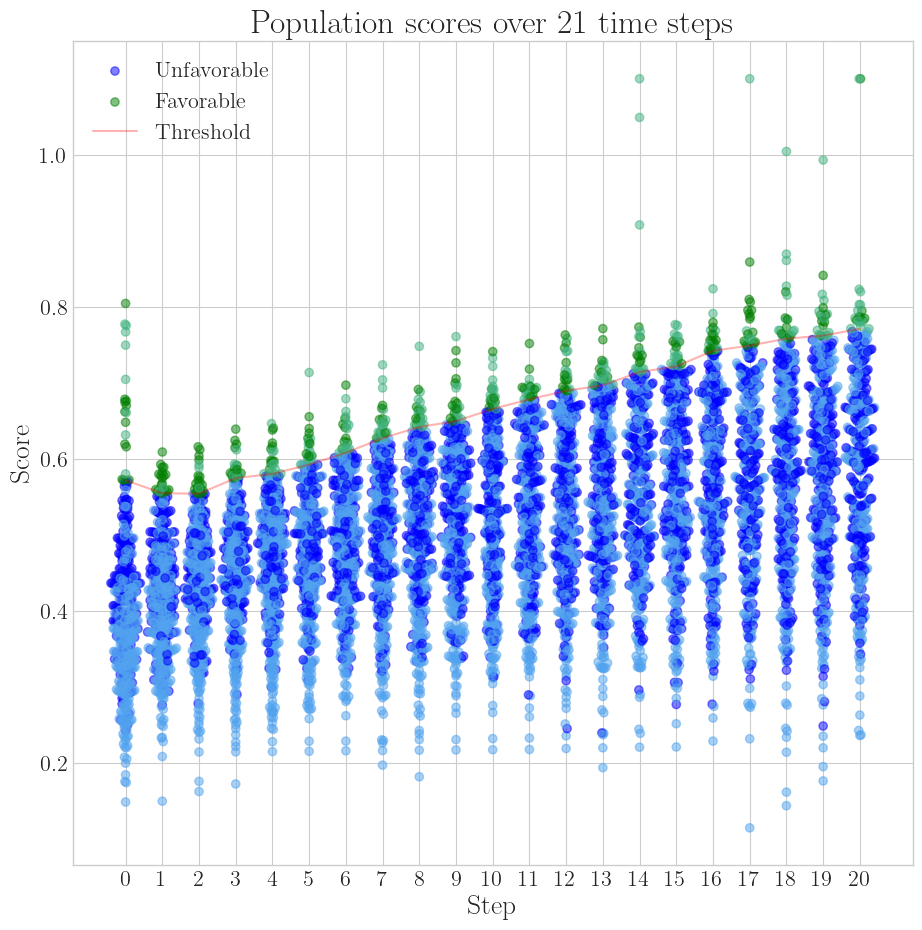

In [25]:
environment.plot.agent_scores(color_feature="groups")

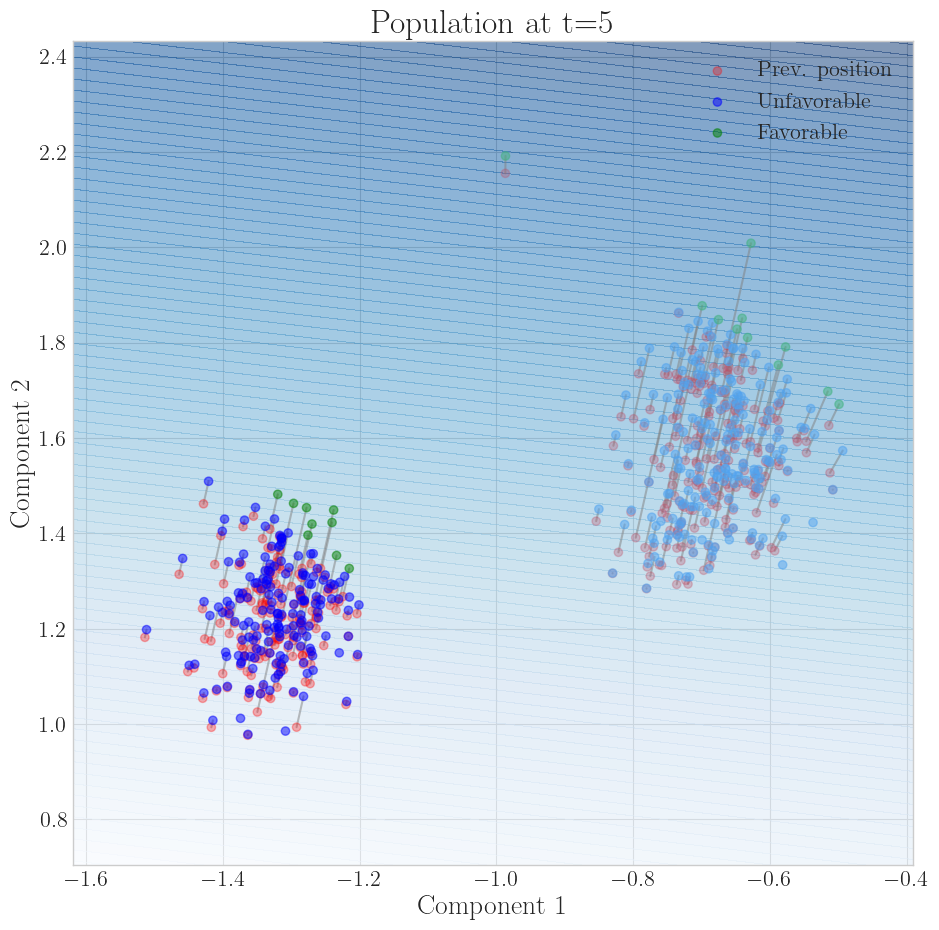

In [26]:
ax = environment.plot.scatter(5, color_feature="groups")

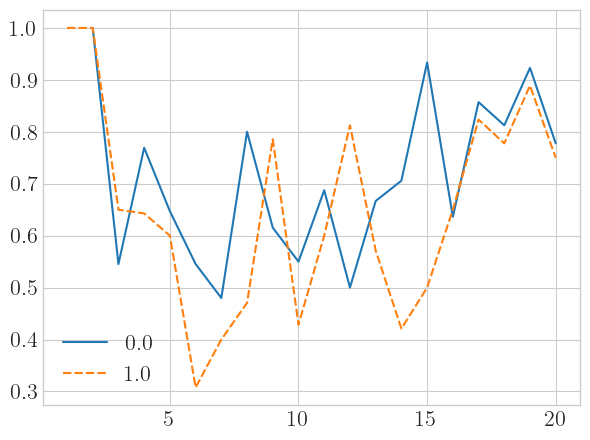

In [27]:
fairness_metrics_per_time_step(environment)

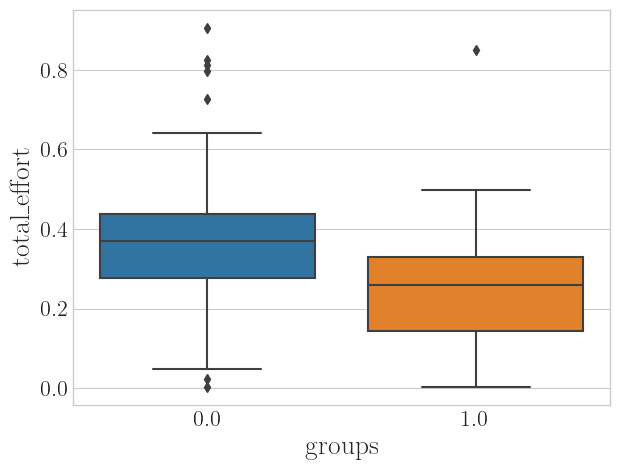

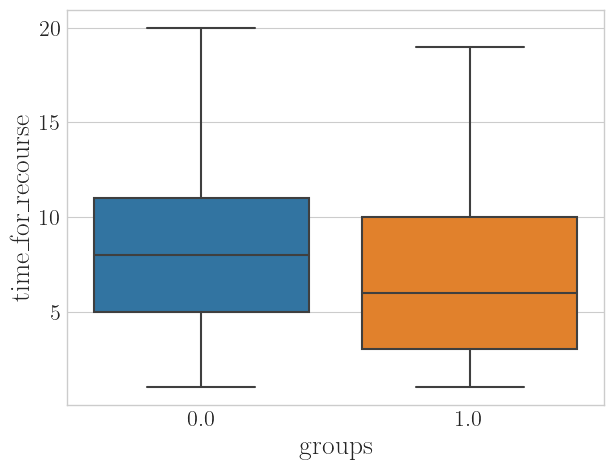

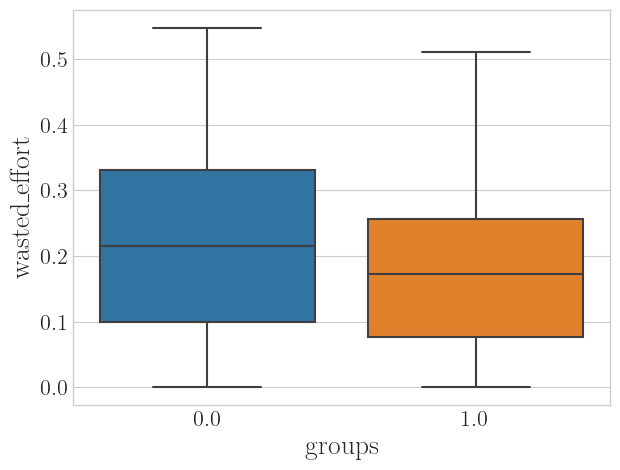

{'etr_disparity': 1.4777688367821582,
 'disparate_ttr': 1.4362528560548364,
 'wasted_effort': 1.28324043017621}

In [28]:
fairness_metrics_overall_visualizations(environment)
# Boxplots for different qualification values

# Draft code

In [29]:
ts = 0
counts = pd.concat([environment.metadata_[ts]["X"]["groups"], environment.metadata_[ts]["outcome"]], axis=1).groupby(["groups", 0]).size()

prop_dis = counts[0., 1] / (counts[0., 1] + counts[0., 0])
prop_adv = counts[1., 1] / (counts[1., 1] + counts[1., 0])
prop_dis / prop_adv

0.6666666666666667

In [30]:
environment.analysis.agents_info().favorable_step.min()

0.0

In [31]:
df_fair_grouped = df_fair.groupby(["groups", "effort_bins"]).mean()
df_fair_grouped["size"] = df_fair.groupby(["groups", "effort_bins"]).size()
# df_fair_grouped.loc[1]
# df_fair_grouped.loc[0]
df_fair_grouped

NameError: name 'df_fair' is not defined

In [ ]:
environment.metadata_[5]["threshold_index"]
environment.metadata_[5]["effort"]

In [ ]:
df

In [ ]:
counts = Counter(df["groups"])

In [ ]:
Counter(environment.X_.groups)

In [ ]:
Counter(environment.get_all_agents().groups)